# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

This is a classification problem.

In supervised learning, a model is trained make predictions based on a training set of features and corresponding labelled output. Supervised learning problems generally fall into one of two categories: classification or regression. In classification problems, the features are used to predict which of a set of classes a given sample belongs to. Regression problems, on the other hand, try to extrapolate a result based on the given features.

A useful heuristic to determine whether a problem is a classification or regression is to consider the type of prediction being made. If the output is discrete--limited to a finite set of possibilities--then the problem is likely to be classification. If, on the other hand, the result is a continuous distribution, then it is most likely a regression problem.

The model we are building in this project is designed to predict whether a student might benefit from an early intervention. To determine whether a student is a candidate for intervention, we will predict whether the student is likely to graduate or not. Those students at risk for not graduating are good candidates for early intervention. This is clearly a discrete result: a student either will graduate or they won't. We are working on a binary classification problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
# Each row of the student_data data frame corresponds to a student.
n_students = student_data.shape[0]

# TODO: Calculate number of features
# Each column of the student_data dataframe, except the last, corresponds to a feature.
n_features = student_data.shape[1]

# TODO: Calculate passing students
# Count the length of the data frame where the 'passed' column is 'yes'.
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
# Count the length of the data frame where the 'passed' column is 'no'.
n_failed = len(student_data[student_data['passed'] == 'no'])

# TODO: Calculate graduation rate
# Find proportion of passing students to total students.
grad_rate = 100. * float(n_passed) / float(n_students)

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 31
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [4]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.model_selection import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
# It's important to shuffle the data set before splitting out the training and test sets
# to avoid any bias in the ordering of the samples. Here we will set a constant random
# seed so that the splits will be made deterministically.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all,
                                                    train_size=num_train, test_size=num_test,
                                                    random_state=1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

The sklearn packages offers several different methods of supervised classification. For this project, we will select three models that take very different approaches to classification: decision trees, support vector machines, and k-nearest neighbors.

**Decision Trees**

Decisions trees are arguably one of the simplest models but still highly effective. By operating on the data one feature at a time, they are robust to different kinds of features and often will not require any additional normalization of the features.

The predictions made by decision trees can often explained to nontechnical stakeholders through the use of decision diagrams, which could be extremely valuable to convince parents and policymakers to make decisions based on its predictions.

Decision trees can be susceptible to overfitting. By splitting samples into smaller and smaller pieces, a decision tree will be able to eventually construct very nonlinear decision boundaries that perfectly predict the training set. Unfortunately, this is not likely to generalize well to unseen data. It will be important to tune the classifier to avoid falling into one of these high variance solutions.

Because of the ease with which decision trees can be interpreted as flow diagrams, they are often used in operations management and other business process modeling.

**Support Vector Machines**

Support vector machines work by classifying samples that reside on one side or another of decision boundary. For data sets that are linearly separately, support vector machines will choose a boundary that maximizes the margin between classes. Through the use of a technique known as the "kernel trick", support vector machines are also able to determine nonlinear decision boundaries by temporarily synthesizing higher order features from a combination of the original features that can be linearly separated and then mapping that boundary back to the original space.

With the strong geometric focus on generating decision boundaries, the predictions made by a support vector machine model will be easy to support with scatter plots and other visualizations when presenting the results to the school district. 

Support vector machines are also susceptible to overfitting. By using the kernel trick to work in higher dimensions, the model may make predictions that do not generalize well. Another weakness is that by placing more emphasis on points near the decision boundary (the "support vectors"), support vector machines often deal poorly with data sets with samples that overlap at the edges.

Support vector machines are widely used in biological sciences, where they have been successful in various application such as classifying protein compounds.

**K-Nearest Neighbors**

Unlike decision trees and support vector machines, k-nearest neighbors is a non-parametric, instance based machine learning model. It effectively memorizes the training set and in exchange is able make more nuanced predictions for new data.

K-nearest neighbors has several advantages that would be beneficial for this project. First, its focus on similar cases brings a much more human touch to the problem. Administrators can identify what worked for similar students to individualize an intervention program for individual students. In addition, the model is easily updated with new student data without requiring potentially expensive retraining that other models might need.

Because the k-nearest neighbors model relies so much on the conept of distance, it's important that a good distance metric can be found. In addition, it will be most effective only when there are sufficient samples nearby. It may be difficult to predict results for students with unique profiles.

K-nearest neighbors is particularly effective where an object can have multiple labels. For example, gene researchers have found that it can often assign functions of genes from expression profiles better than support vector machines.

**References**

* Wikipedia, [Decision tree](https://en.wikipedia.org/wiki/Decision_tree).
* Wikipedia, [Support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).
* Wikipedia, [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).
* [Top 10 algorithms in data mining](http://www.cs.umd.edu/~samir/498/10Algorithms-08.pdf).

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [6]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [7]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
# Each of these models has various tuning parameters, but we will start
# with just the defaults to get a better intuition for the basic behavior
# of each classifier.
#
# Note that the decision tree classifier makes some random decisions, so we
# will fix a random state to enable reproducible runs.
clf_A = DecisionTreeClassifier(random_state=1)
clf_B = SVC()
clf_C = KNeighborsClassifier()

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in [clf_A, clf_B, clf_C]:
    for (X, y) in [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]:
        train_predict(clf, X, y, X_test, y_test)
        print "----------"

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0019 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.6829.
----------
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0013 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0002 seconds.
F1 score for test set: 0.7023.
----------
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0020 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.6984.
----------
Training a SVC using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0007 seconds.
F1 score for training set: 0.8591.
Made predictions in 0.0011 seconds.
F1 score for test set: 0.8333.
----------
Trainin

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Decision Tree**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                0.0012s  |               0.0002s  |          1.0000  |         0.6829  |
| 200               |                0.0012s  |               0.0002s  |          1.0000  |         0.7023  |
| 300               |                0.0017s  |               0.0001s  |          1.0000  |         0.6984  |

** Classifer 2 - Support Vector Machine**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                0.0010s  |               0.0007s  |          0.8591  |         0.8333  |
| 200               |                0.0028s  |               0.0010s  |          0.8581  |         0.8408  |
| 300               |                0.0056s  |               0.0017s  |          0.8584  |         0.8462  |

** Classifer 3 - K-Nearest Neighbor**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |                0.0005s  |               0.0013s  |          0.7883  |         0.7727  |
| 200               |                0.0005s  |               0.0023s  |          0.8345  |         0.7971  |
| 300               |                0.0008s  |               0.0021s  |          0.8558  |         0.7681  |

Note that these results are taken from a previous run of the model training and may not exactly match the values

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

Although each model has its advantages, we will choose the decision tree model as the best model to solve this problem.

It's interesting to note that the performance of the three models closely matched our intuition of how they would perform.
* The decision tree model, without additional tuning, was able to classify each data point in the training set to acheive perfect precision and recall. Unfortunately, this did not generalize to the test set, which received the worst F1 score of the three models.
* The support vector machine was able to acheive very good results with even the smallest training set. The model was able to effectively generalize to the test set, with only a small gap between the training and the test score.
* The k-nearest neighbor model deferred the cost of learning from fitting time to query time. The training score increased steadily with more data. The model also genereralized to the test data better than the untuned decision tree but not as well as the support vector machine.

The usual method to pick the best model is to choose the one that is best able to generalize to the unseen test set, in this case as measured by the F1 score. Applying this rule would lead us to choose the support vector machine, which scored significantly better on the testing set than either of the two other models. However, in this case we have only tested the untuned models, so the support vector machine isn't necessarily the best model to actually use.

For now, we will recommend proceeding with the decision tree model because of it's best mix of technical and non-technical properties.

* While the decision tree model was not as fast to train as the k-nearest neighbors, it was still much faster to train than the support vector machine. The decision tree model, however, really shined with it's fast prediction times. Taken together, this means that the decision tree model should require fewer resources and cost less to train and make predictions.
* The decision tree model's algorithm will be simpler to explain to the board of supervisors, which should make it easier to get buy in on the project.
* The model should make possible to understand which factors are the most important considerations likely to require student intervention. This could help make decisions to improve the school program as a whole, which could reduce the need for interventions in the first place.

Of course, as has been noted above, the untuned decision tree model had poor results for the test score. If we are not able to tune the algorithm to exceed the scores of the support vector machine, we will need to revisit this recommendation.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The decision tree model works the same way you might solve the problem by hand. During the training process, the model will consider all factors that could indicate a high likelihood that a student will graduate, picks the one that best explains previous student graduations, and then divides the data into smaller groups based on that factor. By repeating this process, the model is able to build up a virtual flowchart of factors to consider before predicting whether a given student is likely to graduate without additional intervention.

The effectiveness of the model will be judged on how well it is able to balance the concepts of precision and recall in its predictions. These are just fancy words to describe how good its predictions are. A high precision means that most of the students that it predicts will graduate actually will graduate. This is important to ensure that students at risk for not graduating aren't overlooked and don't get the help they need. On the other hand, high recall means that that students who will graduate are accurately predicted to graduate. This is important to keep costs down by not trying to intervene in cases where it wasn't necessary.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [8]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
# As shown above, decision trees are subject to overfitting. To combat
# this, we will be experimenting with two parameters:
# - max_depth: the maximum depth of the tree being generated
# - min_samples_split: the minimum number of samples present to try another split
parameters = {
    'random_state': [1],
    'max_depth': range(1, 10),
    'min_samples_split': range(10, 300, 10)
}

# TODO: Initialize the classifier
clf = DecisionTreeClassifier()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0002 seconds.
Tuned model has a training F1 score of 0.7972.
Made predictions in 0.0002 seconds.
Tuned model has a testing F1 score of 0.8531.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

The final training F1 score for the tuned model is 0.7972, compared with the untuned score of 1.0.

The final testing F1 score for the tuned model is 0.8531, compared with the untuned score of 0.6984.

We chose to further explore the decision tree model, hoping that after tuning the model to reduce overfitting we would be able to beat the scores of the other two models that we chose not to use. We appear to have succeeded. The training F1 scored dropped significantly, but in excange we were rewarded with a significantly better test F1 score. The test score is the more important result as it indicates how the model is likely to work with new data samples that weren't seen during training.

### Additional Exploration

The simple nature of decision trees will allow us to gain some additional insight on the final tuned model.

In [9]:
# Report the tuned parameters
print "Tuned model has max_depth of {}.".format(clf.get_params()['max_depth'])
print "Tuned model has min_samples_split of {}".format(clf.get_params()['min_samples_split'])

Tuned model has max_depth of 1.
Tuned model has min_samples_split of 10


The maximum depth of 1 is surprising. Could a model with all of the factors considered really be explained by only considering one factor? Let's visualize the tree to find out how it was built.

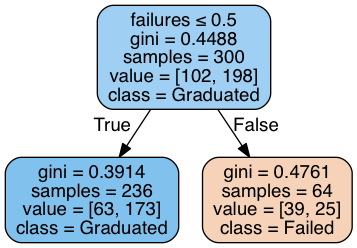

In [10]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X_all.columns,  
                         class_names=['Failed','Graduated'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

Perhaps unsurprisingly, as this chart shows, students that have previously failed courses are at severe risk for not graduating.

If, however, instead of pruning the tree to maximize the crossvalidation score we allow the tree to continue splitting across additional features, some interesting insights emerge. After splitting on failure, the tree then would split on available free time, whether the student has a nonparent guardian, and number of absenses.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.